In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


## Load Data

In [2]:
# Load the clean_data CSV file from previous EDA_QAQC_Datarock notebook
df = pd.read_csv('clean_data.csv')
df=df.set_index("id")
## rename columns for personal preference
df = df.replace('A', 'proximal')
df = df.replace('B', 'distal')
## create a few subset dfs 
df_label=df[['label']]
df_meta=df[['holeid','from', 'to']]
df_elements=df[['Au', 'Pb', 'Fe', 'Mo', 'Cu', 'S', 'Zn']]
df

,Unnamed: 0,holeid,from,to,Au,Pb,Fe,Mo,Cu,S,Zn,label,interval_length
id,,,,,,,,,,,,,
A03356,1,SOLVE003,571,581.0,0.152000,1982.00,50860.0,75.4000,4.800,1822.0000,36.4000,proximal,10.0
A04764,2,SOLVE003,581,591.0,0.068000,1064.80,57940.0,29.2000,3.000,740.4000,36.6000,proximal,10.0
A04626,3,SOLVE003,591,601.0,0.074000,891.60,48620.0,63.0000,4.200,820.8000,39.6000,proximal,10.0
A05579,4,SOLVE003,601,611.0,0.043125,801.25,51025.0,56.0625,4.875,745.6875,32.3125,proximal,10.0
A04127,6,SOLVE004,551,561.0,0.098000,2679.00,59280.0,93.0000,3.000,2085.6000,23.4000,proximal,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
A06258,4638,SOLVE291,1281,1291.0,0.030000,74.80,53460.0,2.4000,3.000,3300.0000,27.6000,?,10.0
A04915,4639,SOLVE291,1291,1301.0,0.064000,208.20,51500.0,2.6000,3.000,4200.0000,29.4000,?,10.0
A06596,4640,SOLVE291,1301,1311.0,0.024000,145.40,55040.0,2.6000,3.000,6160.0000,34.6000,?,10.0


## Create Features

z-score the elements to normalize for use in analysis

In [3]:
#find element z-scores
z_scores = df_elements.apply(zscore)
z_scores=z_scores.reset_index()
## rename the elements as z_scored
columns_to_rename = ['Au', 'Pb', 'Fe', 'Mo', 'Cu', 'S', 'Zn']
z_scores.columns = [col + '_z' if col in columns_to_rename else col for col in z_scores.columns]
z_scores = z_scores.drop(columns=['id']) 
z_scores.head()

,Au_z,Pb_z,Fe_z,Mo_z,Cu_z,S_z,Zn_z
0,2.210664,2.257489,0.215944,0.915925,-0.222228,-0.561654,-0.297995
1,0.523282,0.769660,0.728635,0.284304,-0.398941,-0.656242,-0.291811
2,0.643809,0.488705,0.053737,0.746399,-0.281132,-0.649211,-0.199062
3,0.023596,0.342145,0.227893,0.651554,-0.214865,-0.655780,-0.424365
4,1.125919,3.388122,0.825670,1.156543,-0.398941,-0.538602,-0.699907


Create some geochem ratios as features. Would try out more if time permitted. 

In [4]:
#Create geochem ratios and add to new features df
df_features = pd.DataFrame()

df_features['Pb_Cu_Ratio'] = df_elements['Pb'] / (df_elements['Cu']) 
df_features['Pb_Zn_Ratio'] = df_elements['Pb'] / (df_elements['Zn']) 
df_features['Pb_Mo_Ratio'] = df_elements['Pb'] / (df_elements['Mo']) 
df_features['Pb_S_Ratio'] = df_elements['Pb'] / (df_elements['S']) 
df_features['Pb_Fe_Ratio'] = df_elements['Pb'] / (df_elements['Fe']) 
df_features['Cu_Mo_Ratio'] = df_elements['Cu'] / (df_elements['Mo']) 
df_features['Zn_Cu_Ratio'] = df_elements['Zn'] / (df_elements['Cu']) 
df_features['Cu_Au_Ratio'] = df_elements['Cu'] / (df_elements['Au']) 
df_features['Zn_Mo_Ratio'] = df_elements['Zn'] / (df_elements['Mo']) 
df_features

,Pb_Cu_Ratio,Pb_Zn_Ratio,Pb_Mo_Ratio,Pb_S_Ratio,Pb_Fe_Ratio,Cu_Mo_Ratio,Zn_Cu_Ratio,Cu_Au_Ratio,Zn_Mo_Ratio
id,,,,,,,,,
A03356,412.916667,54.450549,26.286472,1.087816,0.038970,0.063660,7.583333,31.578947,0.482759
A04764,354.933333,29.092896,36.465753,1.438142,0.018378,0.102740,12.200000,44.117647,1.253425
A04626,212.285714,22.515152,14.152381,1.086257,0.018338,0.066667,9.428571,56.756757,0.628571
A05579,164.358974,24.796905,14.292085,1.074512,0.015703,0.086957,6.628205,113.043478,0.576366
A04127,893.000000,114.487179,28.806452,1.284522,0.045192,0.032258,7.800000,30.612245,0.251613
...,...,...,...,...,...,...,...,...,...
A06258,24.933333,2.710145,31.166667,0.022667,0.001399,1.250000,9.200000,100.000000,11.500000
A04915,69.400000,7.081633,80.076923,0.049571,0.004043,1.153846,9.800000,46.875000,11.307692
A06596,48.466667,4.202312,55.923077,0.023604,0.002642,1.153846,11.533333,125.000000,13.307692


## PCA Analysis

In [5]:
# Separate elements and labels
X = df_elements  
y = df['label']  

# Standardize elements
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA 
pca = PCA(n_components=5)  # Reduce to 5 components (after experimenting with up to 7)
X_pca = pca.fit_transform(X_scaled)

# Create a df for the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [6]:
# create a labels df for use in the xy plots below
y = pd.DataFrame(y)
y=y.reset_index()
# Add the Label column to PCA df
pca_df= pca_df.assign(label=y['label']) 
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,label
0,3.324857,0.180128,0.310549,-0.281847,0.047210,proximal
1,1.177206,-0.180498,0.376473,0.335381,-0.687442,proximal
2,1.177875,-0.361527,-0.256176,0.287242,-0.147228,proximal
3,0.717242,-0.487086,-0.176213,0.588358,-0.277872,proximal
4,3.582608,0.112723,0.831985,0.666519,-0.267775,proximal


Create XY Plots of PC1 & PC2 and PC3 & PC4

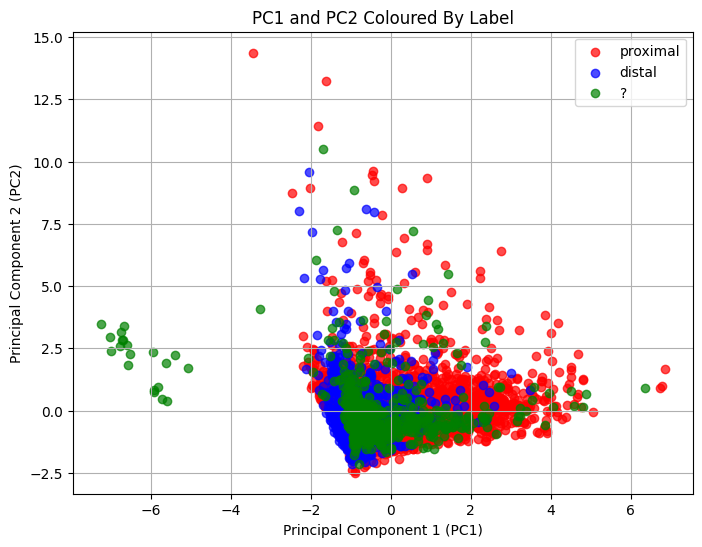

In [7]:
# Define a color map for the Label column
color_map = {'proximal': 'red', 'distal': 'blue', '?': 'green'}

# Plot the PCA results
plt.figure(figsize=(8, 6))
for label, color in color_map.items():
    subset = pca_df[pca_df['label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], color=color, label=label, alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PC1 and PC2 Coloured By Label')
plt.legend()
plt.grid(True)
plt.show()

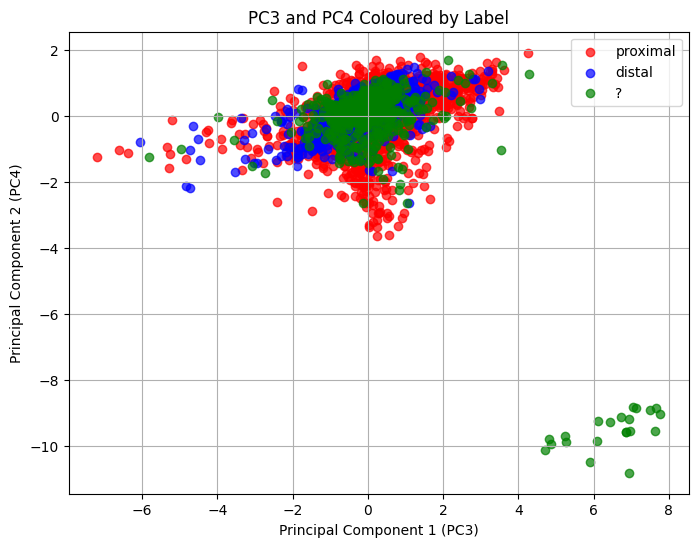

In [8]:
# Define a color map for the Label column
color_map = {'proximal': 'red', 'distal': 'blue', '?':'green'}

# Plot the PCA results
plt.figure(figsize=(8, 6))
for label, color in color_map.items():
    subset = pca_df[pca_df['label'] == label]
    plt.scatter(subset['PC3'], subset['PC4'], color=color, label=label, alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Principal Component 1 (PC3)')
plt.ylabel('Principal Component 2 (PC4)')
plt.title('PC3 and PC4 Coloured by Label')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
## assess the explained variance to decide whether to add another component or not
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {explained_variance[0]:.2f}, PC2 = {explained_variance[1]:.2f}, "
      f"PC3 = {explained_variance[2]:.2f}, PC4 = {explained_variance[3]:.2f}, PC5 = {explained_variance[4]:.2f}")

Explained Variance: PC1 = 0.23, PC2 = 0.23, PC3 = 0.17, PC4 = 0.13, PC5 = 0.10


## Create Final Features df

In [10]:
# combine all features into final df
df_features=df_features.reset_index()
df_features.head()
df_features = pd.concat([df_features, pca_df], axis=1)
df_features = pd.concat([df_features, z_scores], axis=1)
df_features

,id,Pb_Cu_Ratio,Pb_Zn_Ratio,Pb_Mo_Ratio,Pb_S_Ratio,Pb_Fe_Ratio,Cu_Mo_Ratio,Zn_Cu_Ratio,Cu_Au_Ratio,Zn_Mo_Ratio,...,PC4,PC5,label,Au_z,Pb_z,Fe_z,Mo_z,Cu_z,S_z,Zn_z
0,A03356,412.916667,54.450549,26.286472,1.087816,0.038970,0.063660,7.583333,31.578947,0.482759,...,-0.281847,0.047210,proximal,2.210664,2.257489,0.215944,0.915925,-0.222228,-0.561654,-0.297995
1,A04764,354.933333,29.092896,36.465753,1.438142,0.018378,0.102740,12.200000,44.117647,1.253425,...,0.335381,-0.687442,proximal,0.523282,0.769660,0.728635,0.284304,-0.398941,-0.656242,-0.291811
2,A04626,212.285714,22.515152,14.152381,1.086257,0.018338,0.066667,9.428571,56.756757,0.628571,...,0.287242,-0.147228,proximal,0.643809,0.488705,0.053737,0.746399,-0.281132,-0.649211,-0.199062
3,A05579,164.358974,24.796905,14.292085,1.074512,0.015703,0.086957,6.628205,113.043478,0.576366,...,0.588358,-0.277872,proximal,0.023596,0.342145,0.227893,0.651554,-0.214865,-0.655780,-0.424365
4,A04127,893.000000,114.487179,28.806452,1.284522,0.045192,0.032258,7.800000,30.612245,0.251613,...,0.666519,-0.267775,proximal,1.125919,3.388122,0.825670,1.156543,-0.398941,-0.538602,-0.699907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319,A06258,24.933333,2.710145,31.166667,0.022667,0.001399,1.250000,9.200000,100.000000,11.500000,...,0.326377,-0.465791,?,-0.240058,-0.836260,0.404221,-0.082091,-0.398941,-0.432400,-0.570058
4320,A04915,69.400000,7.081633,80.076923,0.049571,0.004043,1.153846,9.800000,46.875000,11.307692,...,-0.056621,-0.278202,?,0.442930,-0.619866,0.262289,-0.079356,-0.398941,-0.353693,-0.514409
4321,A06596,48.466667,4.202312,55.923077,0.023604,0.002642,1.153846,11.533333,125.000000,13.307692,...,0.432318,-0.413845,?,-0.360585,-0.721737,0.518635,-0.079356,-0.398941,-0.182287,-0.353644
4322,A07560,27.400000,3.281437,42.153846,0.019228,0.001976,1.538462,8.350000,363.636364,12.846154,...,0.558139,-0.459607,?,-0.621727,-0.779810,0.549049,-0.079356,-0.300767,-0.222515,-0.390744


## Model Training

Prepare data for classification model 

In [11]:
df_features_unlabelled = df_features.loc[df_features['label'] == '?'] ## create df for later use in predicting unlabelled data
df_features_labels = df_features.loc[df_features['label'] != '?'] ## remove the "?" label aka the unlabelled set from training/test dfs
df_features_labels

,id,Pb_Cu_Ratio,Pb_Zn_Ratio,Pb_Mo_Ratio,Pb_S_Ratio,Pb_Fe_Ratio,Cu_Mo_Ratio,Zn_Cu_Ratio,Cu_Au_Ratio,Zn_Mo_Ratio,...,PC4,PC5,label,Au_z,Pb_z,Fe_z,Mo_z,Cu_z,S_z,Zn_z
0,A03356,412.916667,54.450549,26.286472,1.087816,0.038970,0.063660,7.583333,31.578947,0.482759,...,-0.281847,0.047210,proximal,2.210664,2.257489,0.215944,0.915925,-0.222228,-0.561654,-0.297995
1,A04764,354.933333,29.092896,36.465753,1.438142,0.018378,0.102740,12.200000,44.117647,1.253425,...,0.335381,-0.687442,proximal,0.523282,0.769660,0.728635,0.284304,-0.398941,-0.656242,-0.291811
2,A04626,212.285714,22.515152,14.152381,1.086257,0.018338,0.066667,9.428571,56.756757,0.628571,...,0.287242,-0.147228,proximal,0.643809,0.488705,0.053737,0.746399,-0.281132,-0.649211,-0.199062
3,A05579,164.358974,24.796905,14.292085,1.074512,0.015703,0.086957,6.628205,113.043478,0.576366,...,0.588358,-0.277872,proximal,0.023596,0.342145,0.227893,0.651554,-0.214865,-0.655780,-0.424365
4,A04127,893.000000,114.487179,28.806452,1.284522,0.045192,0.032258,7.800000,30.612245,0.251613,...,0.666519,-0.267775,proximal,1.125919,3.388122,0.825670,1.156543,-0.398941,-0.538602,-0.699907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,A06296,42.100000,11.694444,20.240385,0.018728,0.010243,0.480769,3.600000,357.142857,1.730769,...,0.030411,1.294464,proximal,-0.280233,-0.274675,-0.490816,0.169464,0.288276,1.244931,-0.310361
3647,A05391,26.043478,5.704762,22.462500,0.007560,0.006413,0.862500,4.565217,287.500000,3.937500,...,0.324669,2.234172,proximal,0.121524,-0.374599,0.591049,0.103841,0.661337,3.436480,0.524379
3648,A06529,69.708333,12.392593,34.854167,0.010595,0.007328,0.500000,5.625000,200.000000,2.812500,...,0.194710,1.606144,proximal,-0.360585,-0.414828,-0.160608,0.016344,-0.222228,2.040745,-0.588608
3649,A06648,45.161290,9.859155,29.787234,0.009655,0.006728,0.659574,4.580645,281.818182,3.021277,...,0.051239,1.601328,proximal,-0.400761,-0.503397,-0.453161,0.013610,-0.084784,1.815119,-0.545325


In [12]:
# Separate features and labels
X = df_features_labels.drop(columns=['label', 'id'])  
y = df_features_labels['label'] 
X.shape

(3651, 21)

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# Define models to test
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Store results
    results[name] = accuracy

/Users/testtest/anaconda3/envs/datarock/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
print("Model Accuracies:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.2f}")

# Identify the best model
best_model_name = max(results, key=results.get)
best_model_accuracy = results[best_model_name]
print(f"\nBest Model: {best_model_name} with accuracy {best_model_accuracy:.2f}")

Model Accuracies:
Logistic Regression: 0.81
Random Forest: 0.84
SVM: 0.69
KNN: 0.75
Gradient Boosting: 0.82

Best Model: Random Forest with accuracy 0.84


In [18]:
# Get the best model
best_model = models[best_model_name]

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

      distal       0.80      0.64      0.72       349
    proximal       0.85      0.93      0.89       747

    accuracy                           0.84      1096
   macro avg       0.83      0.79      0.80      1096
weighted avg       0.83      0.84      0.83      1096


Confusion Matrix:
[[225 124]
 [ 55 692]]


Find the Feature Importance

In [19]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = best_model.feature_importances_

# Create a df for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
1,Pb_Zn_Ratio,0.106538
4,Pb_Fe_Ratio,0.089718
15,Pb_z,0.081769
8,Zn_Mo_Ratio,0.075802
9,PC1,0.055381
0,Pb_Cu_Ratio,0.048444
13,PC5,0.044436
3,Pb_S_Ratio,0.044252
11,PC3,0.044158
19,S_z,0.043956


## Make predictions for the unlabelled data

prepare unlabelled data

In [21]:
X_unlabelled= df_features_unlabelled.drop(columns=['label']) 
X_unlabelled=X_unlabelled.set_index('id')
X_unlabelled

,Pb_Cu_Ratio,Pb_Zn_Ratio,Pb_Mo_Ratio,Pb_S_Ratio,Pb_Fe_Ratio,Cu_Mo_Ratio,Zn_Cu_Ratio,Cu_Au_Ratio,Zn_Mo_Ratio,PC1,...,PC3,PC4,PC5,Au_z,Pb_z,Fe_z,Mo_z,Cu_z,S_z,Zn_z
id,,,,,,,,,,,,,,,,,,,,,
A04920,193.600000,15.488000,13.260274,1.075556,0.008050,0.068493,12.500000,40.000000,0.856164,0.575405,...,0.316060,0.584272,-0.681441,0.412799,-0.172480,0.886860,0.384106,-0.448028,-0.681638,-0.457214
A05729,206.562500,17.303665,11.845878,0.590179,0.013017,0.057348,11.937500,80.000000,0.684588,0.500708,...,-0.214549,0.623937,-0.318386,-0.039179,0.114639,0.210151,0.647965,-0.379306,-0.623045,-0.242345
A05270,248.294118,24.684211,17.735294,0.649385,0.016469,0.071429,10.058824,65.384615,0.718487,0.812086,...,-0.034076,0.440934,-0.318992,0.201876,0.411816,0.244910,0.535859,-0.359671,-0.607304,-0.366011
A05634,129.625000,9.217778,18.684685,0.406667,0.009683,0.144144,14.062500,76.190476,2.027027,0.041158,...,-0.499957,-0.007548,-0.250304,0.000997,-0.284732,-0.364816,0.188604,-0.379306,-0.631791,-0.032114
A04208,517.454545,31.274725,22.321569,1.497895,0.019334,0.043137,16.545455,23.404255,0.713725,1.681785,...,0.419995,0.357366,-0.557103,1.045567,0.889050,0.796704,0.582342,-0.477480,-0.654528,-0.297995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A06258,24.933333,2.710145,31.166667,0.022667,0.001399,1.250000,9.200000,100.000000,11.500000,-0.492192,...,0.188734,0.326377,-0.465791,-0.240058,-0.836260,0.404221,-0.082091,-0.398941,-0.432400,-0.570058
A04915,69.400000,7.081633,80.076923,0.049571,0.004043,1.153846,9.800000,46.875000,11.307692,0.022953,...,0.250615,-0.056621,-0.278202,0.442930,-0.619866,0.262289,-0.079356,-0.398941,-0.353693,-0.514409
A06596,48.466667,4.202312,55.923077,0.023604,0.002642,1.153846,11.533333,125.000000,13.307692,-0.577147,...,0.314456,0.432318,-0.413845,-0.360585,-0.721737,0.518635,-0.079356,-0.398941,-0.182287,-0.353644


Run the predict and predict_proba methods 

In [22]:
#create a new df for the predictions
predictions_df = pd.DataFrame()
#Predict labels for the unlabeled dataset using the model ranndom forest model 
predicted_labels = best_model.predict(X_unlabelled)

# Add the predicted labels to the new predictions df
predictions_df['predicted_label'] = predicted_labels
predictions_df

,predicted_label
0,proximal
1,proximal
2,proximal
3,proximal
4,proximal
...,...
668,proximal
669,proximal
670,distal
671,distal


In [23]:
#find prediction probabilties for unlabelled data
probabilities = best_model.predict_proba(X_unlabelled)
probabilities_df = pd.DataFrame(probabilities)
probabilities_df.rename(columns={1: 'probability_proximal'}, inplace=True) # select and rename column 1 of predict_proba (proximal probabilities)
probabilities_df=probabilities_df[['probability_proximal']]
probabilities_df

,probability_proximal
0,0.97
1,1.00
2,1.00
3,0.92
4,1.00
...,...
668,0.68
669,0.84
670,0.47
671,0.47


In [24]:
#concat predictions & probabilties for unlabelled data
df_predictions_probabilities = pd.concat([predictions_df, probabilities_df], axis=1)
X_unlabelled=X_unlabelled.reset_index()
df_predictions_probabilities = pd.concat([X_unlabelled, df_predictions_probabilities], axis=1)
df_predictions_probabilities = pd.merge(df_predictions_probabilities, df_meta, on='id', how='inner')
df_predictions_probabilities.head()

,id,Pb_Cu_Ratio,Pb_Zn_Ratio,Pb_Mo_Ratio,Pb_S_Ratio,Pb_Fe_Ratio,Cu_Mo_Ratio,Zn_Cu_Ratio,Cu_Au_Ratio,Zn_Mo_Ratio,...,Fe_z,Mo_z,Cu_z,S_z,Zn_z,predicted_label,probability_proximal,holeid,from,to
0,A04920,193.600000,15.488000,13.260274,1.075556,0.008050,0.068493,12.500000,40.000000,0.856164,...,0.886860,0.384106,-0.448028,-0.681638,-0.457214,proximal,0.97,SOLVE225W1,581,591.0
1,A05729,206.562500,17.303665,11.845878,0.590179,0.013017,0.057348,11.937500,80.000000,0.684588,...,0.210151,0.647965,-0.379306,-0.623045,-0.242345,proximal,1.00,SOLVE225W1,591,601.0
2,A05270,248.294118,24.684211,17.735294,0.649385,0.016469,0.071429,10.058824,65.384615,0.718487,...,0.244910,0.535859,-0.359671,-0.607304,-0.366011,proximal,1.00,SOLVE225W1,601,611.0
3,A05634,129.625000,9.217778,18.684685,0.406667,0.009683,0.144144,14.062500,76.190476,2.027027,...,-0.364816,0.188604,-0.379306,-0.631791,-0.032114,proximal,0.92,SOLVE225W1,611,621.0
4,A04208,517.454545,31.274725,22.321569,1.497895,0.019334,0.043137,16.545455,23.404255,0.713725,...,0.796704,0.582342,-0.477480,-0.654528,-0.297995,proximal,1.00,SOLVE225W1,641,651.0


In [25]:
## check if label break down makes sense
label_count = df_predictions_probabilities['predicted_label'].value_counts()
label_count

predicted_label
distal      339
proximal    334
Name: count, dtype: int64

## Plot the predictions for an example unlabelled drill hole

In [26]:
#select drill hole to use for viz
SOLVE236_df = df_predictions_probabilities[df_predictions_probabilities['holeid'] == 'SOLVE236']

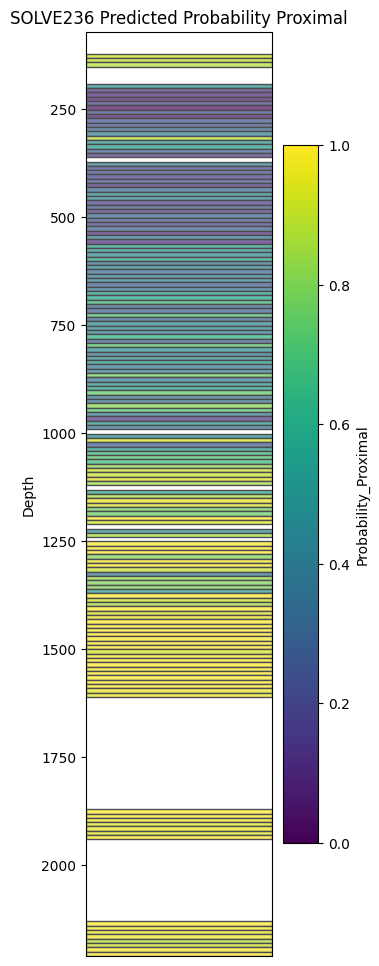

In [27]:
# create downhole plot of predicted proximal probability
cmap = cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=1)

fig, ax = plt.subplots(figsize=(3, 12))

for _, row in SOLVE236_df.iterrows():
    ax.barh(
        y=(row['from'] + row['to']) / 2,  
        width=1,  # Bar width
        height=row['to'] - row['from'], 
        color=cmap(norm(row['probability_proximal'])),
        edgecolor='black',
        align='center'
    )
    
ax.axvspan(0, 1, color='white', alpha=0.3)
ax.set_ylim(max(df["to"]), min(df["from"]))  # Reverse depth axis
ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_ylabel("Depth")
ax.set_title("SOLVE236 Predicted Probability Proximal")
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Probability_Proximal")
plt.show()

/var/folders/zs/pty16hcd2clbfx__htmdtdxr0000gn/T/ipykernel_3114/446685252.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


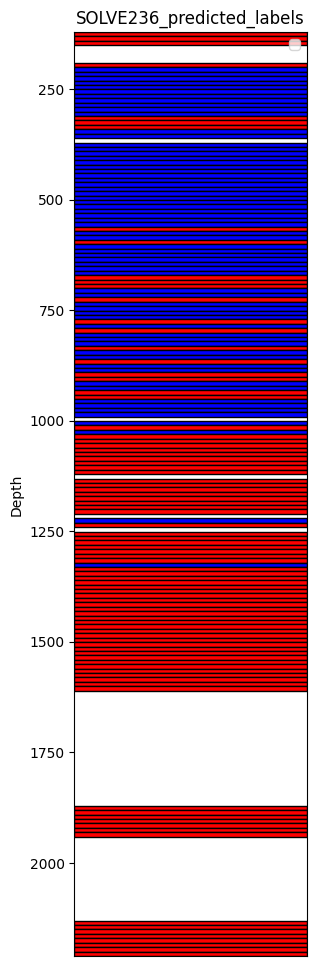

In [28]:
# create downhole plot of predicted label (proximal or distal)
colors = {
    "proximal": "red",
    "distal": "blue"
}

fig, ax = plt.subplots(figsize=(3, 12))

for _, row in SOLVE236_df.iterrows():
    ax.barh(
        y=(row['from'] + row['to']) / 2,  
        width=1,  # Bar width
        height=row['to'] - row['from'],  
        color=colors.get(row['predicted_label'], "black"),
        edgecolor='black',
        align='center'
    )
    
ax.set_ylim(max(SOLVE236_df["to"]), min(SOLVE236_df["from"]))  # Reverse depth axis
ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_ylabel("Depth")
ax.set_title("SOLVE236_predicted_labels")
plt.legend()
plt.show()

Next Steps -- See report